# Evaluation of (SW2GIC-AT) LSTMs trained to predict local E and GIC

This script loads LSTMs trained in 4_ModelTraining and evaluates and compares their forecasting skill. The different outputs can be compared to three different targets: the geoelectric field components, the modelled GICs (GIC_fit), or the measured GICs. Since GIC_fit functions only as an intermediary for lack of more GIC measurements, the only results considered in the study are ability in predicting the geoelectric field components (Ex and Ey) and the GICs at two substations (#1 and #5).

### Contents
There are three sections to this script:
1. **Geoelectric Field Forecast from LSTM-E**: Evaluate forecasts of Ex and Ey from the LSTM-E models.
2. **GIC Forecast from LSTM-E**: Evaluate forecasts of GICs from the LSTM-E models.
3. **GIC Forecast from LSTM-GIC**: Evaluate forecasts of GICs from the LSTM-GIC models.

### Input and Output

- See parameters.json for paths to files and plots.
- The samples for training, testing and for virtual real-time application are saved to "datapath" with the prefixes "traindata_", "testdata_" and "rtdata_". Scaling objects (sklearn) are saved alongside under scaler_. Separate files are saved for each possible target (6 in total): Ex_FUR, Ey_FUR, GIC1 and GIC2 measurements (GIC_), and GIC1 and GIC2 fits (GIC_fit_) from the modelled geoelectric field data.
- LSTM models trained prior to this are loaded from "models/".
- Result plots are saved to "plotpath".
- Tables are pasted into https://www.tablesgenerator.com/ for formatting before being inserted into LaTeX.

**Author**: Rachel L. Bailey (ZAMG, r.bailey@zamg.ac.at), May 2021 - Sep 2021.

In [1]:
import os, sys
import copy
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import keras

import sw2gic

with open('parameters.json', 'r') as fp:
    Params = json.load(fp)
    
sns.set_style(Params["sns_style"])

#### Parameters

In [2]:
data_path = Params['datapath']
plot_path = Params['plotpath']

c_SS1, c_SS5 = Params['c_SS1'], Params['c_SS5']
c_Ex, c_Ey = Params['c_Ex'], Params['c_Ey']

ip_tr, op_tr, os_tr = [120, 40, 10]

In [3]:
custom_objects = {'BasicAttention': sw2gic.BasicAttention, 'min_max_loss': sw2gic.min_max_loss}

#### Functions for plots and tables of results

In [4]:
from sklearn.metrics import auc

def plot_roc_det_curves(v, c='b', max_E_level=136, step_level=1, print_level=5, marker_points={}, axes=[], savestr='', annotations=[],
                        E_hon=None, df_hon=None, label_str='', sub_str='', title_str='E', return_axes=False):
    '''
    Plots the ROC and DET curves side-by-side for the variable (v) looked at.
    Useful reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_det.html
    
    Parameters
    ----------
    v   :: DataStorer Object
        Contains data under the attributes v.y_rt_sc, v.pred_rt, v.pers_rt
    max_E_level :: float (default=136)
        Defines the maximum level to use as a threshold.
    step_level :: float (default=1)
        The step size to go from 0 to max_E_level in thresholds.
    savestr :: str (default='')
        Suffix of filename: roc_det_{savestr}.png
    E_hon :: str ('Ee' or 'En', default None)
        If not None, plots the data from the Honkonen et al. (2018) defined by the str.
    df_hon :: pd.DataFrames (default=None)
        Dataframe containing the Honkonen et al. (2018) data.
    return_axes :: bool (default=False)
        If True, will return the axis objects and not save to file.
        
    Returns
    -------
    None  :: The plot is saved to "plots/roc_det_{}.png".format(v.varname)
    '''
    
    if label_str[0] == 'E':
        unit = 'mV/km'
    else:
        unit = 'A'

    FPR, FNR, TPR = [100.], [0.], [100.]
    FPR_pers, FNR_pers, TPR_pers = [100.], [0.], [100.]
    FPR_cm, FNR_cm, TPR_cm = [100.], [0.], [100.]
    FPR_hon, FNR_hon, TPR_hon = [100.], [0.], [100.]

    fpr_steps = np.arange(0, max_E_level, step_level)
    for i in fpr_steps[1:]:

        # LSTM + Persistence results vs. GIC fit
        CM, CM_pers = sw2gic.compute_CM(v.y_rt_sc, v.pred_rt, v.pers_rt, threshold=i, verbose=False)
        m_lstm = sw2gic.calc_event_rates(CM)
        m_pers = sw2gic.calc_event_rates(CM_pers)
        FPR.append(m_lstm['FPR'] * 100)
        FNR.append(m_lstm['FNR'] * 100)
        TPR.append(m_lstm['TPR'] * 100)
        FPR_pers.append(m_pers['FPR'] * 100)
        FNR_pers.append(m_pers['FNR'] * 100)
        TPR_pers.append(m_pers['TPR'] * 100)

        # Honkonen et al. results
        if E_hon != None:
            CM_hon, _ = sw2gic.compute_CM(np.abs(df_hon['measured '+E_hon]), np.abs(df_hon['modeled '+E_hon]), 
                                          np.abs(df_hon['measured '+E_hon]), threshold=i, verbose=False)
            m_hon = sw2gic.calc_event_rates(CM_hon)
            FPR_hon.append(m_hon['FPR'] * 100)
            FNR_hon.append(m_hon['FNR'] * 100)
            TPR_hon.append(m_hon['TPR'] * 100)

        # Climatological mean
        CM_cm, _ = sw2gic.compute_CM(v.y_rt_sc, np.full(v.pred_rt.shape, np.mean(v.y_rt_sc)), v.pers_rt, threshold=i, verbose=False)
        m_cm = sw2gic.calc_event_rates(CM_cm)
        FPR_cm.append(m_cm['FPR'] * 100)
        FNR_cm.append(m_cm['FNR'] * 100)
        TPR_cm.append(m_cm['TPR'] * 100)
        
    def get_auc(FPR, TPR):
        aucdata = np.hstack((np.array(FPR).reshape(-1,1), np.array(TPR).reshape(-1,1)))
        aucdata = aucdata[aucdata[:,0].argsort()]
        aucdata = aucdata[~np.isnan(aucdata).any(axis=1)]
        return auc(aucdata[:,0]/100., aucdata[:,1]/100.)
    
    if len(axes) == 0:
        fig, (ax_roc, ax_det) = plt.subplots(1, 2, figsize=(10,4.6))
        make_legend = True
    else:
        ax_roc, ax_det = axes[0], axes[1]
        make_legend = False
    alpha_start, alpha_step = 0.1, 0.9/len(fpr_steps)

    # Plot the AUC curve:
    # -------------------
    x_off, y_off = 3, -1
    for i, i_step in enumerate(fpr_steps[:-2]):
        if i == 0:
            #label_lstm = r'LSTM-{}, AUC={:.2f}'.format(label_str, get_auc(FPR, TPR))
            #label_pers = r'PERS-{}, AUC={:.2f}'.format(label_str, get_auc(FPR_pers, TPR_pers))
            label_lstm = r'{}'.format(label_str)+'$_{pred'+sub_str+'}$'+', AUC={:.2f}'.format(get_auc(FPR, TPR))
            label_pers = r'{}'.format(label_str)+'$_{pers'+sub_str+'}$'+', AUC={:.2f}'.format(get_auc(FPR_pers, TPR_pers))
            if len(axes) != 0:
                label_mean = 'mean, AUC={:.2f}'.format(get_auc(FPR_cm, TPR_cm))
            else:
                label_mean = None
        else:
            label_lstm, label_pers, label_mean = None, None, None
        ax_roc.plot(FPR[i:i+2], TPR[i:i+2], '-', c=c, label=label_lstm)
        ax_roc.plot(FPR_pers[i:i+2], TPR_pers[i:i+2], '-.', c=c, label=label_pers)
        ax_roc.plot(FPR_cm[i:i+2], TPR_cm[i:i+2], 'k--', alpha=0.5, label=label_mean)
        if i_step in marker_points.keys():
            ax_roc.plot(FPR[i], TPR[i], marker=marker_points[int(i_step)], ms=10, color=c)
            ax_roc.plot(FPR_pers[i], TPR_pers[i], marker=marker_points[int(i_step)], ms=10, color=c, 
                        markerfacecolor='white')
        if E_hon != None:
            if np.mean(FPR_hon[i:i+2]) != np.nan:
                ax_roc.plot(FPR_hon[i:i+2]+x_off, TPR_hon[i:i+2]+y_off, 'g-', alpha=0.7, label='hon, AUC= {:.2f}'.format(get_auc(FPR_hon, TPR_hon)))
    ax_roc.legend(loc='lower right')

    # Plot the DET curve:
    # -------------------
    lower_xlim = 3e-2
    for i, i_step in enumerate(fpr_steps[:-2]):
        ax_det.plot(FNR[i:i+2], FPR[i:i+2], '-', c=c)#, alpha=alpha_start + i*alpha_step)
        ax_det.plot(FNR_pers[i:i+2], FPR_pers[i:i+2], '-.', c=c)#, alpha=alpha_start + i*alpha_step)
        if i_step in marker_points.keys():
            ax_det.plot(FNR[i], FPR[i], marker=marker_points[int(i_step)], ms=10, c=c)
            ax_det.plot(FNR_pers[i], FPR_pers[i], marker=marker_points[int(i_step)], ms=10, c=c, 
                        markerfacecolor='white')
            # Fake points to create legend:
            if make_legend == True:
                ax_det.plot(-100, -100, marker=marker_points[int(i_step)], ms=10, lw=0, c='darkgrey', label='{} {}'.format(i_step, unit))
        if E_hon != None:
            if FNR_hon[i:i+2] != np.nan:
                ax_det.plot(FNR_hon[i:i+2], FPR_hon[i:i+2], 'g-', label='hon', alpha=alpha_start + i*alpha_step)
    ax_det.legend(loc='upper right')
    
    # Formatting:
    ax_roc.set_xlim((0, 100))
    ax_roc.set_ylim((0, 100))
    ax_det.set_yscale('log')
    ax_det.set_xlim((0, 100))
    ax_det.set_ylim((lower_xlim, 1.2e2))
    lpad = -2
    ax_det.set_xlabel("False Negative Rate (%)")
    ax_det.set_ylabel("False Positive Rate (%)", labelpad=lpad)
    ax_roc.set_xlabel("False Positive Rate (%)")
    ax_roc.set_ylabel("True Positive Rate (%)", labelpad=lpad)
    ax_roc.set_title("ROC curve for {}".format(title_str))
    ax_det.set_title("DET curve for {}".format(title_str))
    
    if len(annotations) > 0:
        ax_roc.text(-0.1, 0.88, "("+annotations[0]+")", transform=ax_roc.transAxes, fontsize=14)
        ax_det.text(-0.1, 0.88, "("+annotations[1]+")", transform=ax_det.transAxes, fontsize=14)

    # Save file:
    if return_axes:
        return [ax_roc, ax_det]
    else:
        if savestr == '':
            savepath = "plots/roc_det_{}.png".format(v.varname)
        else:
            savepath = "plots/roc_det_{}.png".format(savestr)
        print("Saving plot to {}.".format(savepath))
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
        plt.show()

        
def print_table_of_results(v, thresholds=[], label_sub='', label_add=''):
    
    variables = ['TP', 'FP', 'FN', 'TN', 'POD', 'POFD', 'HSS', 'TSS', 'BS']
    str_format = {'TP': '{:.0f}', 'FP': '{:.0f}', 'FN': '{:.0f}', 'TN': '{:.0f}', 'HSS': '{:.2f}',
                  'POD': '{:.1f}', 'POFD': '{:.1f}', 'TS': '{:.2f}', 'TSS': '{:.2f}', 'BS':'{:.1f}'}
    mult = {x:(1 if x not in ['POD', 'POFD'] else 100) for x in variables}
    
    print("Results for {}\n---------------------".format(v.varname))
    title_str = '\t'.join(['Model']+['N$_{'+'events'+'}$']+['{}'.format(x) for x in variables])
    print(title_str)

    table_str, nrow = [], 0
    max_vals = {}
    
    if 'GIC' in v.varname:
        label = r"\GICpred" + label_add + "{" + str(label_sub) + "}"
        label_pers = r"\GICpers{" + str(label_sub) + "}"
    else:
        label = r"\Epred" + label_add + "{" + str(label_sub) + "}"
        label_pers = r"\Epers" + label_add + "{" + str(label_sub) + "}"
        

    # LSTM
    for threshold in thresholds:
        CM, CM_pers = sw2gic.compute_CM(v.y_rt_sc, v.pred_rt, v.pers_rt, threshold=threshold, verbose=False)
        m_lstm = sw2gic.calc_event_rates(CM)
        colstr = '\t'.join(["{}(TH={})".format(label, threshold)] + [str(m_lstm['TP']+m_lstm['FN'])] + 
                           [str_format[x].format(m_lstm[x]*mult[x]) for x in variables])
        table_str.append(colstr)
        nrow += 1
        print(colstr)
            
    # PERS
    for threshold in thresholds:
        CM, CM_pers = sw2gic.compute_CM(v.y_rt_sc, v.pred_rt, v.pers_rt, threshold=threshold, verbose=False)
        m_pers = sw2gic.calc_event_rates(CM_pers)
        colstr = '\t'.join(["{}(TH={})".format(label_pers, threshold)] + [str(m_pers['TP']+m_pers['FN'])] + 
                           [str_format[x].format(m_pers[x]*mult[x]) for x in variables])
        table_str.append(colstr)
        nrow += 1
        print(colstr)
            
    print("\n")

# 1. Geoelectric Field Forecast from LSTM-E

### Load data

In [6]:
# LOAD DATA
Ex = sw2gic.DataStorer('Ex_FUR', ip_tr, op_tr, os_tr)
Ex.load_training_data(data_path)
Ex.load_realtime_data(data_path, year='all', enc=Ex.enc)

Ey = sw2gic.DataStorer('Ey_FUR', ip_tr, op_tr, os_tr)
Ey.load_training_data(data_path, enc=Ex.enc)
Ey.load_realtime_data(data_path, year='all', enc=Ex.enc)

# CALCULATE METRICS FOR PERSISTENCE
m = Ex.calc_pers_metrics()
m = Ey.calc_pers_metrics()

# Parameters for plotting and tables
max_E_level = 130
step_level, print_level = 5, 30
marker_points = {30: "^", 60: "o", 90: "s"}
E_thresholds = [30, 60, 90]

Loading years [2000, 2001, 2017, 2019, 2020]...
Loading years [2000, 2001, 2017, 2019, 2020]...


In [7]:
# Load final models
model_Ex = keras.models.load_model('models/lstm_{}.h5'.format('Ex_FUR'), custom_objects=custom_objects)
model_Ey = keras.models.load_model('models/lstm_{}.h5'.format('Ey_FUR'), custom_objects=custom_objects)

Ex.make_predictions(model_Ex, show_plot=False)
Ey.make_predictions(model_Ey, show_plot=False)

### ROC and DET curves - LSTM-E vs. E

Saving plot to plots/roc_det_Ey_FUR.png.


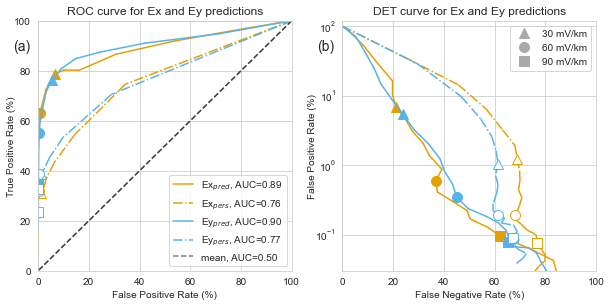

In [8]:
axes = plot_roc_det_curves(Ex, max_E_level=max_E_level, step_level=step_level, label_str='Ex', 
                           marker_points=marker_points, print_level=print_level, return_axes=True, c=c_Ex)
plot_roc_det_curves(Ey, max_E_level=max_E_level, step_level=step_level, label_str='Ey', annotations=['a', 'b'],
                    marker_points=marker_points, print_level=print_level, axes=axes, title_str="Ex and Ey predictions", c=c_Ey)

### Table of results - LSTM-E vs. E

In [9]:
print_table_of_results(Ex, thresholds=E_thresholds, label_sub='x')
print_table_of_results(Ey, thresholds=E_thresholds, label_sub='y')

Results for Ex_FUR
---------------------
Model	N$_{events}$	TP	FP	FN	TN	POD	POFD	HSS	TSS	BS
\Epred{x}(TH=30)	3092	2436	11749	656	160506	78.8	6.8	0.26	0.72	4.6
\Epred{x}(TH=60)	494	312	1038	182	173815	63.2	0.6	0.34	0.63	2.7
\Epred{x}(TH=90)	175	66	164	109	175008	37.7	0.1	0.33	0.38	1.3
\Epers{x}(TH=30)	3092	958	2128	2134	170127	31.0	1.2	0.30	0.30	1.0
\Epers{x}(TH=60)	494	157	335	337	174518	31.8	0.2	0.32	0.32	1.0
\Epers{x}(TH=90)	175	41	130	134	175042	23.4	0.1	0.24	0.23	1.0


Results for Ey_FUR
---------------------
Model	N$_{events}$	TP	FP	FN	TN	POD	POFD	HSS	TSS	BS
\Epred{y}(TH=30)	2989	2279	9328	710	163030	76.2	5.4	0.29	0.71	3.9
\Epred{y}(TH=60)	559	307	600	252	174188	54.9	0.3	0.42	0.55	1.6
\Epred{y}(TH=90)	241	84	135	157	174971	34.9	0.1	0.36	0.35	0.9
\Epers{y}(TH=30)	2989	1156	1804	1833	170554	38.7	1.0	0.38	0.38	1.0
\Epers{y}(TH=60)	559	216	335	343	174453	38.6	0.2	0.39	0.38	1.0
\Epers{y}(TH=90)	241	79	158	162	174948	32.8	0.1	0.33	0.33	1.0




# 2. GIC Forecast from LSTM-E

### ROC and DET curves - LSTM-E vs. GIC_meas

In [9]:
a_SS1, b_SS1 = Params["a_SS1"], Params["b_SS1"]
a_SS5, b_SS5 = Params["a_SS5"], Params["b_SS5"]
# Test a reasonable level to use as an event threshold
print("SS1 currents at 60 mV/km: {:.1f} A".format(a_SS1 * 60 + b_SS1 * 60))
print("SS5 currents at 60 mV/km: {:.1f} A".format(a_SS5 * 60 + b_SS5 * 60))

SS1 currents at 60 mV/km: 4.2 A
SS5 currents at 60 mV/km: 3.6 A


In [10]:
event_threshold_E = 60 # mV/km
event_threshold_GIC = 4 # A
gic_pred_SS1 = a_SS1 * Ex.pred_rt_signed + b_SS1 * Ey.pred_rt_signed
gic_pred_SS5 = a_SS5 * Ex.pred_rt_signed + b_SS5 * Ey.pred_rt_signed
gic_SS1      = a_SS1 * Ex.y_rt_signed    + b_SS1 * Ey.y_rt_signed
gic_SS5      = a_SS5 * Ex.y_rt_signed    + b_SS5 * Ey.y_rt_signed

print("RMSE (scaled)")
print("    Ex: {:.0f} mV/km".format(mean_squared_error(np.squeeze(Ex.pred_rt), np.squeeze(Ex.y_rt_sc))))
print("    Ey: {:.0f} mV/km".format(mean_squared_error(np.squeeze(Ey.pred_rt), np.squeeze(Ey.y_rt_sc))))
print("")

print("RMSE (signed)")
print("    Ex: {:.0f} mV/km".format(mean_squared_error(np.squeeze(Ex.pred_rt_signed), np.squeeze(Ex.y_rt_signed))))
print("    Ey: {:.0f} mV/km".format(mean_squared_error(np.squeeze(Ey.pred_rt_signed), np.squeeze(Ey.y_rt_signed))))
print("")

print("Corr. (scaled)")
print("    Ex: {:.2f}".format(pearsonr(np.squeeze(Ex.pred_rt), np.squeeze(Ex.y_rt_sc))[0]))
print("    Ey: {:.2f}".format(pearsonr(np.squeeze(Ey.pred_rt), np.squeeze(Ey.y_rt_sc))[0]))
print("")

print("Corr. (signed)")
print("    Ex: {:.2f}".format(pearsonr(np.squeeze(Ex.pred_rt_signed), np.squeeze(Ex.y_rt_signed))[0]))
print("    Ey: {:.2f}".format(pearsonr(np.squeeze(Ey.pred_rt_signed), np.squeeze(Ey.y_rt_signed))[0]))

RMSE (scaled)
    Ex: 126 mV/km
    Ey: 111 mV/km

RMSE (signed)
    Ex: 261 mV/km
    Ey: 287 mV/km

Corr. (scaled)
    Ex: 0.60
    Ey: 0.61

Corr. (signed)
    Ex: 0.48
    Ey: 0.32


#### Load GIC measurements

In [11]:
# SS1
GIC1_meas = sw2gic.DataStorer('GIC_SS1', ip_tr, op_tr, os_tr)
GIC1_meas.load_realtime_data(data_path, year='allmeas')

# SS5
GIC5_meas = sw2gic.DataStorer('GIC_SS5', ip_tr, op_tr, os_tr)
GIC5_meas.load_realtime_data(data_path, year='allmeas')

GIC1_meas.pred_rt = np.abs(gic_pred_SS1[-len(GIC1_meas.y_rt_sc):])
GIC5_meas.pred_rt = np.abs(gic_pred_SS5[-len(GIC5_meas.y_rt_sc):])

# And load measurements
pickled_data_path_gic = os.path.join(data_path,'df_features_gic.p')
df_gic = pd.read_pickle(pickled_data_path_gic)

# Parameters for plotting and tables:
step_level = 0.25
marker_points = {1: "^", 2: "o", 4: "s", 6: ">"}
arrow = r'$\rightarrow$'
gic_thresholds = [2, 4, 6]

Loading years [2017, 2019, 2020]...
Loading years [2017, 2019, 2020]...


Saving plot to plots/roc_det_GIC_E.png.


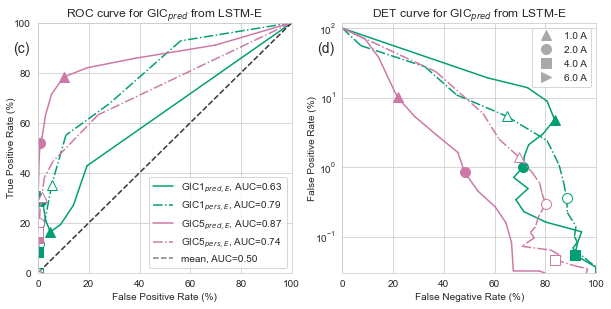

In [12]:
axes = plot_roc_det_curves(GIC1_meas, max_E_level=8, step_level=step_level, label_str='GIC1', sub_str=',E', marker_points=marker_points, 
                           c=c_SS1, return_axes=True)
plot_roc_det_curves(GIC5_meas, max_E_level=8, step_level=step_level, label_str='GIC5', sub_str=',E', marker_points=marker_points, annotations=['c', 'd'], 
                    c=c_SS5, axes=axes, title_str='GIC$_{pred}$ from LSTM-E', savestr='GIC_E')

### Table of results - LSTM-E vs. GIC_meas

In [13]:
# FINAL model
print_table_of_results(GIC1_meas, thresholds=gic_thresholds, label_add='E', label_sub='1')
print_table_of_results(GIC5_meas, thresholds=gic_thresholds, label_add='E', label_sub='2')

Results for GIC_SS1
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpredE{1}(TH=2)	432	124	1060	103697	308	28.7	1.0	0.15	0.28	2.7
\GICpredE{1}(TH=4)	24	2	57	105108	22	8.3	0.1	0.05	0.08	2.5
\GICpredE{1}(TH=6)	2	0	2	105185	2	0.0	0.0	-0.00	-0.00	1.0
\GICpers{1}(TH=2)	432	50	375	104382	382	11.6	0.4	0.11	0.11	1.0
\GICpers{1}(TH=4)	24	0	26	105139	24	0.0	0.0	-0.00	-0.00	1.1
\GICpers{1}(TH=6)	2	0	3	105184	2	0.0	0.0	-0.00	-0.00	1.5


Results for GIC_SS5
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpredE{2}(TH=2)	307	159	681	80649	148	51.8	0.8	0.27	0.51	2.7
\GICpredE{2}(TH=4)	43	6	13	81581	37	14.0	0.0	0.19	0.14	0.4
\GICpredE{2}(TH=6)	12	0	1	81624	12	0.0	0.0	-0.00	-0.00	0.1
\GICpers{2}(TH=2)	307	61	237	81093	246	19.9	0.3	0.20	0.20	1.0
\GICpers{2}(TH=4)	43	7	38	81556	36	16.3	0.0	0.16	0.16	1.0
\GICpers{2}(TH=6)	12	0	11	81614	12	0.0	0.0	-0.00	-0.00	0.9




# 3. GIC Forecast from LSTM-GIC

### Load objects

In [14]:
GIC1_NAME, GIC5_NAME = 'GIC_fit_SS1', 'GIC_fit_SS5'

# LOAD DATA
GIC1_fit = sw2gic.DataStorer(GIC1_NAME, ip_tr, op_tr, os_tr, predict_sign=False)
GIC1_fit.load_training_data(data_path)
GIC1_fit.load_realtime_data(data_path, year='all')

GIC5_fit = sw2gic.DataStorer(GIC5_NAME, ip_tr, op_tr, os_tr, predict_sign=False)
GIC5_fit.load_training_data(data_path)
GIC5_fit.load_realtime_data(data_path, year='all')

# CALCULATE METRICS FOR PERSISTENCE
m = GIC1_fit.calc_pers_metrics()
m = GIC5_fit.calc_pers_metrics()

# And load measurements
pickled_data_path_gic = os.path.join(data_path,'df_features_gic.p')
df_gic = pd.read_pickle(pickled_data_path_gic)

# Parameters for plotting and tables
step_level = 0.25
marker_points = {1: "^", 2: "o", 4: "s", 6: ">"}
gic_thresholds = [2, 4, 6]

Loading years [2000, 2001, 2017, 2019, 2020]...
Loading years [2000, 2001, 2017, 2019, 2020]...


In [15]:
model_GIC1 = keras.models.load_model('models/lstm_{}.h5'.format(GIC1_fit.varname), custom_objects=custom_objects)
model_GIC5 = keras.models.load_model('models/lstm_{}.h5'.format(GIC5_fit.varname), custom_objects=custom_objects)

GIC1_fit.make_predictions(model_GIC1, show_plot=False)
GIC5_fit.make_predictions(model_GIC5, show_plot=False)

### ROC and DET curves - LSTM-GIC vs. GIC_fit

Saving plot to plots/roc_det_GIC_fit.png.


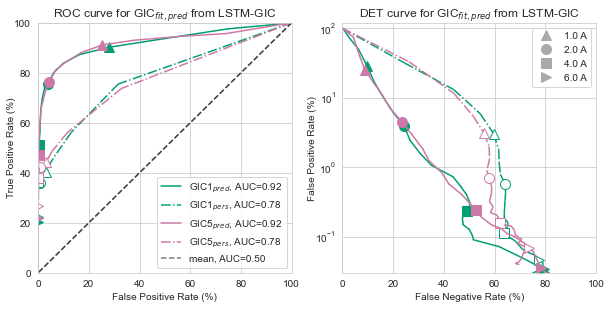

In [16]:
axes = plot_roc_det_curves(GIC1_fit, max_E_level=8, step_level=step_level, label_str='GIC1', marker_points=marker_points, 
                           c=c_SS1, return_axes=True)
plot_roc_det_curves(GIC5_fit, max_E_level=8, step_level=step_level, label_str='GIC5', marker_points=marker_points, c=c_SS5, axes=axes, 
                    title_str='GIC$_{fit,pred}$ from LSTM-GIC', savestr='GIC_fit')

### Table of results - LSTM-GIC vs. GIC_fit

In [17]:
print_table_of_results(GIC1_fit, thresholds=gic_thresholds, label_sub='1')
print_table_of_results(GIC5_fit, thresholds=gic_thresholds, label_sub='5')

Results for GIC_fit_SS1
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpred{1}(TH=2)	1564	1182	6725	167058	382	75.6	3.9	0.24	0.72	5.1
\GICpred{1}(TH=4)	320	163	412	174615	157	50.9	0.2	0.36	0.51	1.8
\GICpred{1}(TH=6)	103	21	59	175185	82	20.4	0.0	0.23	0.20	0.8
\GICpers{1}(TH=2)	1564	561	1007	172776	1003	35.9	0.6	0.35	0.35	1.0
\GICpers{1}(TH=4)	320	116	196	174831	204	36.2	0.1	0.37	0.36	1.0
\GICpers{1}(TH=6)	103	23	80	175164	80	22.3	0.0	0.22	0.22	1.0


Results for GIC_fit_SS5
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpred{5}(TH=2)	1823	1393	6663	143309	430	76.4	4.4	0.27	0.72	4.4
\GICpred{5}(TH=4)	398	188	360	151037	210	47.2	0.2	0.40	0.47	1.4
\GICpred{5}(TH=6)	147	32	53	151595	115	21.8	0.0	0.28	0.22	0.6
\GICpers{5}(TH=2)	1823	771	1043	148929	1052	42.3	0.7	0.42	0.42	1.0
\GICpers{5}(TH=4)	398	151	239	151158	247	37.9	0.2	0.38	0.38	1.0
\GICpers{5}(TH=6)	147	39	103	151545	108	26.5	0.1	0.27	0.26	1.0




### ROC and DET curves - LSTM-GIC vs. GIC_meas

#### Load measurements

In [18]:
# SS1
GIC1_meas = sw2gic.DataStorer('GIC_SS1', ip_tr, op_tr, os_tr)
GIC1_meas.load_realtime_data(data_path, year='allmeas')

# SS5
GIC5_meas = sw2gic.DataStorer('GIC_SS5', ip_tr, op_tr, os_tr)
GIC5_meas.load_realtime_data(data_path, year='allmeas')

# Use predictions from LSTM trained on GIC_fit:
GIC1_meas.pred_rt = GIC1_fit.pred_rt[-len(GIC1_meas.y_rt_sc):]
GIC5_meas.pred_rt = GIC5_fit.pred_rt[-len(GIC5_meas.y_rt_sc):]

step_level = 0.25
marker_points = {1: "^", 2: "o", 4: "s", 6: ">"}

Loading years [2017, 2019, 2020]...
Loading years [2017, 2019, 2020]...


Saving plot to plots/roc_det_GIC.png.


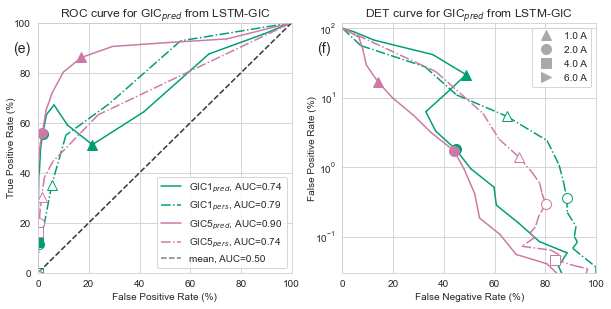

In [19]:
axes = plot_roc_det_curves(GIC1_meas, max_E_level=8, step_level=step_level, label_str='GIC1', marker_points=marker_points, 
                           c=c_SS1, return_axes=True)
plot_roc_det_curves(GIC5_meas, max_E_level=8, step_level=step_level, label_str='GIC5', marker_points=marker_points, c=c_SS5, axes=axes, annotations=['e', 'f'], 
                    title_str='GIC$_{pred}$ from LSTM-GIC', savestr='GIC')

### Table of results - LSTM-GIC vs. GIC_meas

In [20]:
print_table_of_results(GIC1_meas, thresholds=gic_thresholds, label_sub='1')
print_table_of_results(GIC5_meas, thresholds=gic_thresholds, label_sub='5')

Results for GIC_SS1
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpred{1}(TH=2)	432	239	1886	102871	193	55.3	1.8	0.18	0.54	4.9
\GICpred{1}(TH=4)	24	3	26	105139	21	12.5	0.0	0.11	0.12	1.2
\GICpred{1}(TH=6)	2	0	0	105187	2	0.0	0.0	0.00	0.00	0.0
\GICpers{1}(TH=2)	432	50	375	104382	382	11.6	0.4	0.11	0.11	1.0
\GICpers{1}(TH=4)	24	0	26	105139	24	0.0	0.0	-0.00	-0.00	1.1
\GICpers{1}(TH=6)	2	0	3	105184	2	0.0	0.0	-0.00	-0.00	1.5


Results for GIC_SS5
---------------------
Model	N$_{events}$	TP	FP	TN	FN	POD	POFD	HSS	TSS	BS
\GICpred{5}(TH=2)	307	172	1403	79927	135	56.0	1.7	0.18	0.54	5.1
\GICpred{5}(TH=4)	43	7	16	81578	36	16.3	0.0	0.21	0.16	0.5
\GICpred{5}(TH=6)	12	0	4	81621	12	0.0	0.0	-0.00	-0.00	0.3
\GICpers{5}(TH=2)	307	61	237	81093	246	19.9	0.3	0.20	0.20	1.0
\GICpers{5}(TH=4)	43	7	38	81556	36	16.3	0.0	0.16	0.16	1.0
\GICpers{5}(TH=6)	12	0	11	81614	12	0.0	0.0	-0.00	-0.00	0.9




#### Create time series plot

In [27]:
def plot_GIC_time_series(df_gic, t1, t2, gic_meas1, gic_meas2, gic_pred1, gic_pred5, gic_pred1_E=[], gic_pred5_E=[], skip=3):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    c_LSTM = 'k'
    lw_LSTM = 1
    label_meas = "Measured GICs"

    # Measurements:
    ax1.plot_date(df_gic.index[::skip], df_gic['GIC_SS1'][::skip], '-', c=c_SS1, lw=0.75, alpha=0.5, label=label_meas)
    ax2.plot_date(df_gic.index[::skip], df_gic['GIC_SS5'][::skip], '-', c=c_SS5, lw=0.75, alpha=0.5, label=label_meas)

    # Max GIC measurements:
    #ax1.plot_date(t1, gic_meas1, '-', c=c_SS1, lw=1, label='max(|GIC|) (meas)')
    #ax2.plot_date(t2, gic_meas2, '-', c=c_SS5, lw=1, label='max(|GIC|) (meas)')

    # LSTM output:
    ax1.plot_date(t1, gic_pred1, '-', c=c_LSTM,  lw=lw_LSTM, label='Pred. max(|GIC|) (LSTM-GIC)')
    ax2.plot_date(t2, gic_pred5, '-', c=c_LSTM,  lw=lw_LSTM, label='Pred. max(|GIC|) (LSTM-GIC)')
    
    if len(gic_pred1_E) != 0 and len(gic_pred5_E) != 0:
        ax1.plot_date(t1, gic_pred1_E, '--', c=c_LSTM,  lw=lw_LSTM, label='Pred. max(|GIC|) (LSTM-E)')
        ax2.plot_date(t2, gic_pred5_E, '--', c=c_LSTM,  lw=lw_LSTM, label='Pred. max(|GIC|) (LSTM-E)')
        
    for ax, ann in zip([ax1, ax2], ['a', 'b']):
        ax.text(0.01, 0.88, "("+ann+")", transform=ax.transAxes, fontsize=14)

    #plt.xlim([datetime(2017,9,6), datetime(2017,9,11)])
    plt.xlim([datetime(2017,9,4), datetime(2017,9,13)])
    ax1.legend()
    ax2.legend()
    ax1.set_title("Plot of predicted GIC (LSTM-E) vs. measured GIC at SS1 in Sept 2017")
    ax2.set_title("Plot of predicted GIC (LSTM-E) vs. measured GIC at SS5 in Sept 2017")
    ax1.set_ylim((0,10))
    ax2.set_ylim((0,10))
    plt.subplots_adjust(hspace=0.16)
    ax2.set_xlabel("Date in year [UTC]")
    ax1.set_ylabel("Measured and modelled |GIC| [A]")
    ax2.set_ylabel("Measured and modelled |GIC| [A]")
    plt.savefig(os.path.join(plot_path,"gic_predictions.png"), dpi=300, bbox_inches='tight')
    plt.show()

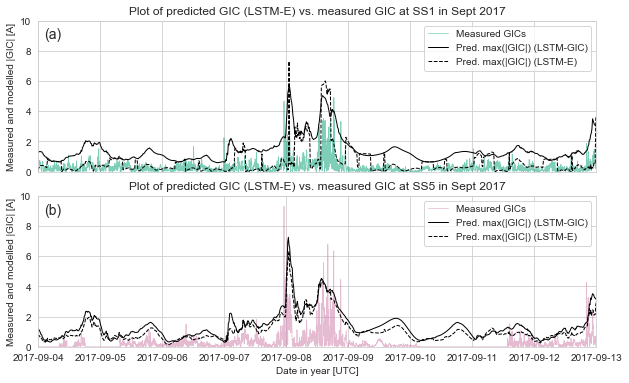

In [28]:
start_rt, end_rt = datetime(2017,1,1)+timedelta(hours=2), datetime(2018,1,1)
run_model_every = 15 # minutes
n_sections = int(365*24*60/run_model_every)
i_rt = np.arange(int(np.ceil((Params['input_tr']+Params['offset_tr'])/run_model_every)),n_sections) * run_model_every
t_rt = [start_rt + timedelta(minutes=int(i)) for i in i_rt]
t_off = int(i_rt[0]/15) - 1

# SS1
gic_meas_SS1 = GIC1_meas.y_rt_sc
gic_SS5_cut = gic_SS5[(gic_SS5.shape[0] - np.array(list(GIC5_meas.year_lens.values())).sum()):]
gic_meas_SS1_toff = gic_meas_SS1[t_off:len(t_rt)+t_off]
gic_pers_SS1_toff = GIC1_meas.pers_rt[t_off:len(t_rt)+t_off]
gic_LSTM_pred1 = GIC1_meas.pred_rt[t_off:len(t_rt)+t_off]
gic_LSTM_E_pred1 = np.abs(gic_pred_SS1[-len(GIC1_meas.y_rt_sc):][t_off:len(t_rt)+t_off])

# SS5
t_rt2 = t_rt[-GIC5_meas.year_lens[2017]:]
gic_meas_SS5 = GIC5_meas.y_rt_sc
gic_meas_SS5_toff = gic_meas_SS5[t_off:len(t_rt2)+t_off]
gic_pers_SS5_toff = GIC5_meas.pers_rt[t_off:len(t_rt2)+t_off]
gic_LSTM_pred5 = GIC5_meas.pred_rt[t_off:len(t_rt2)+t_off]
gic_LSTM_E_pred5 = np.abs(gic_pred_SS5[-len(GIC5_meas.y_rt_sc):][t_off:len(t_rt2)+t_off])

df_gic_abs = df_gic.abs()

plot_GIC_time_series(df_gic_abs, t_rt, t_rt2, np.abs(gic_meas_SS1_toff), np.abs(gic_meas_SS5_toff), 
                     gic_LSTM_pred1, gic_LSTM_pred5, gic_pred1_E=gic_LSTM_E_pred1, gic_pred5_E=gic_LSTM_E_pred5)

In [26]:
# RMSE and PCC for GICs from LSTM-E
# ---------------------------------
# Note: only calculate for GIC_meas > 0 to leave out the data gaps.
rmse_2017_SS1 = np.sqrt(mean_squared_error(gic_meas_SS1_toff[gic_meas_SS1_toff > 0], gic_LSTM_E_pred1[gic_meas_SS1_toff > 0]))
rmse_2017_SS5 = np.sqrt(mean_squared_error(gic_meas_SS5_toff[gic_meas_SS5_toff > 0], gic_LSTM_E_pred5[gic_meas_SS5_toff > 0]))
r_2017_SS1 = pearsonr(np.squeeze(gic_meas_SS1_toff), np.squeeze(gic_LSTM_E_pred1))[0]
r_2017_SS5 = pearsonr(np.squeeze(gic_meas_SS5_toff[gic_meas_SS5_toff > 0]), np.squeeze(gic_LSTM_E_pred5[gic_meas_SS5_toff > 0]))[0]
print("Results for LSTM-E\n-------------------")
print("SS1: RMSE = {:.3f}\tPCC = {:.3f}".format(rmse_2017_SS1, r_2017_SS1))
print("SS5: RMSE = {:.3f}\tPCC = {:.3f}".format(rmse_2017_SS5, r_2017_SS5))
print("")

# RMSE and PCC for GICs from LSTM-E
# ---------------------------------
rmse_2017_SS1 = np.sqrt(mean_squared_error(gic_meas_SS1_toff, gic_LSTM_pred1))
rmse_2017_SS5 = np.sqrt(mean_squared_error(gic_meas_SS5_toff, gic_LSTM_pred5))
r_2017_SS1 = pearsonr(np.squeeze(gic_meas_SS1_toff[gic_meas_SS1_toff > 0]), np.squeeze(gic_LSTM_pred1[gic_meas_SS1_toff > 0]))[0]
r_2017_SS5 = pearsonr(np.squeeze(gic_meas_SS5_toff[gic_meas_SS5_toff > 0]), np.squeeze(gic_LSTM_pred5[gic_meas_SS5_toff > 0]))[0]
print("Results for LSTM-GIC\n---------------------")
print("SS1: RMSE = {:.3f}\tPCC = {:.3f}".format(rmse_2017_SS1, r_2017_SS1))
print("SS5: RMSE = {:.3f}\tPCC = {:.3f}".format(rmse_2017_SS5, r_2017_SS5))
print("")

Results for LSTM-E
-------------------
SS1: RMSE = 0.528	PCC = 0.351
SS5: RMSE = 0.509	PCC = 0.672

Results for LSTM-GIC
---------------------
SS1: RMSE = 0.613	PCC = 0.560
SS5: RMSE = 0.775	PCC = 0.641



## Appendix - Load data from Honkonen (2018) paper

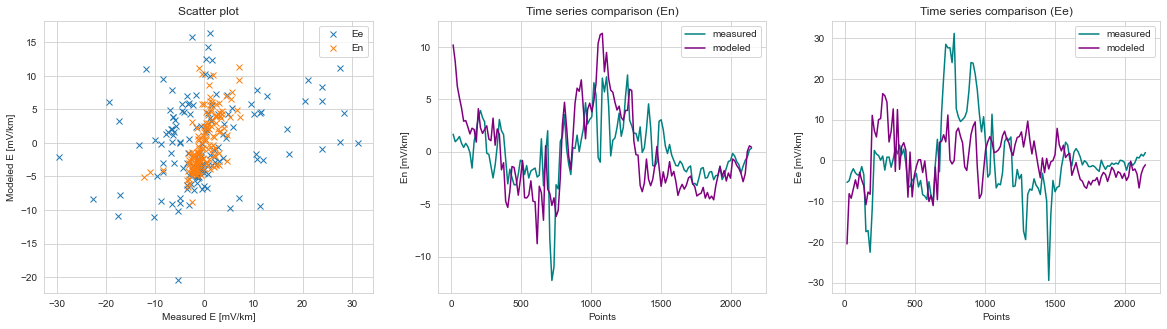

,date,modeled En,modeled Ee,measured En,measured Ee
0,2006-12-14T12:00:00,27.647100,-49.80650,2.039306,-4.960139
1,2006-12-14T12:01:00,10.558900,-35.43520,1.239306,-4.560139
2,2006-12-14T12:02:00,11.970000,-33.41930,1.439306,-3.760139
3,2006-12-14T12:03:00,9.194140,-29.32680,2.739306,-5.360139
4,2006-12-14T12:04:00,10.461000,-27.46720,1.739306,-4.660139
...,...,...,...,...,...
2155,2006-12-15T23:55:00,1.490040,-2.00301,1.239306,-3.160139
2156,2006-12-15T23:56:00,-0.122112,-1.07402,-2.260694,2.139861
2157,2006-12-15T23:57:00,0.965229,-3.48510,1.939306,-2.960139
2158,2006-12-15T23:58:00,-2.232710,-3.61544,-2.260694,3.639861


In [9]:
df_honkonen = pd.read_csv('predictions/kny.txt', sep="\t| ", engine='python')
df_honkonen.columns = ['date', 'modeled En', 'modeled Ee', 'measured En', 'measured Ee', 'n1', 'n2', 'n3']
df_honkonen = df_honkonen.drop(columns=['n1', 'n2', 'n3'])

df_honkonen_resampled = df_honkonen.rolling(window=15).mean()[::15][1:]
#df_honkonen_resampled = df_honkonen[::15]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.plot(df_honkonen_resampled['measured Ee'], df_honkonen_resampled['modeled Ee'], 'x', label='Ee')
ax1.plot(df_honkonen_resampled['measured En'], df_honkonen_resampled['modeled En'], 'x', label='En')
ax1.set_xlabel('Measured E [mV/km]')
ax1.set_ylabel('Modeled E [mV/km]')
ax1.legend()
ax1.set_title("Scatter plot")
ax2.plot(df_honkonen_resampled['measured En'], '-', c='teal', label="measured")
ax2.plot(df_honkonen_resampled['modeled En'], 'r-', c='purple', label="modeled")
ax2.set_xlabel("Points")
ax2.set_ylabel("En [mV/km]")
ax2.legend()
ax2.set_title("Time series comparison (En)")
ax3.plot(df_honkonen_resampled['measured Ee'], '-', c='teal', label="measured")
ax3.plot(df_honkonen_resampled['modeled Ee'], '-', c='purple', label="modeled")
ax3.set_xlabel("Points")
ax3.set_ylabel("Ee [mV/km]")
ax3.legend()
ax3.set_title("Time series comparison (Ee)")

plt.savefig("plots/honkonen_data.png")
plt.show()

df_honkonen

In [11]:
Ex_hon = df_honkonen_resampled['modeled En'].to_numpy()
Ey_hon = df_honkonen_resampled['modeled Ee'].to_numpy()
Ex_hon_meas = df_honkonen_resampled['measured En'].to_numpy()
Ey_hon_meas = df_honkonen_resampled['measured Ee'].to_numpy()

print("RMSE")
print("    Ex: {:.1f} mV/km".format(mean_squared_error(Ex_hon, Ex_hon_meas)))
print("    Ey: {:.1f} mV/km".format(mean_squared_error(Ey_hon, Ey_hon_meas)))
print("")

print("R")
print("    Ex: {:.2f} mV/km".format(pearsonr(Ex_hon, Ex_hon_meas)[0]))
print("    Ey: {:.2f} mV/km".format(pearsonr(Ey_hon, Ey_hon_meas)[0]))

RMSE
    Ex: 10.5 mV/km
    Ey: 97.8 mV/km

R
    Ex: 0.62 mV/km
    Ey: 0.25 mV/km
